In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
import seaborn as sns
import re
folderpath = "/home/jsw/BI/Database/spatial_ref/GSE163108_RAW/"

In [ ]:
# barcode, feature, matrix 파일을 읽어서 AnnData 객체로 바꾼 후 adata_list에 저장.
import glob
import shutil
def read_10x_mtx_multiple(directory):
    # matrix, barcodes, features 파일 검색
    matrix_files = glob.glob(os.path.join(directory, '*matrix.mtx.gz'))
    barcode_files = glob.glob(os.path.join(directory, '*barcodes.tsv.gz'))
    feature_files = glob.glob(os.path.join(directory, '*features.tsv.gz'))
    feature_files += glob.glob(os.path.join(directory, '*genes.tsv.gz'))
    
    adata_list = []
    # print(matrix_files)
    
    for matrix_file in matrix_files:
        # 파일 이름에서 base_name (공통 이름) 추출
        base_name = os.path.basename(matrix_file).split('matrix')[0]
        
        # base_name 으로 barcodes, features (genes) 파일 찾기
        barcode_file = [bf for bf in barcode_files if base_name in bf]
        feature_file = [ff for ff in feature_files if base_name in ff]
        print(matrix_file, barcode_file, feature_file)
        
        if len(barcode_file) == 1 and len(feature_file) == 1:   # 만약 barcode, feature 파일이 하나씩 있는 경우
            matrix_dir = os.path.dirname(matrix_file)
            
            # 임시 디렉토리 생성 및 파일 복사
            temp_dir = os.path.join(directory, base_name + '_temp')
            os.makedirs(temp_dir, exist_ok=True)
            
            shutil.copy(matrix_file, os.path.join(temp_dir, 'matrix.mtx.gz'))
            shutil.copy(barcode_file[0], os.path.join(temp_dir, 'barcodes.tsv.gz'))
            
            if 'features' in feature_file[0]:   # features.tsv.gz 파일인 경우
                # shutil.copy(feature_file[0], os.path.join(temp_dir, 'features.tsv.gz'))
                features = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                if features.shape[1] == 1: # gene name column만 있는 경우
                    features['gene_id'] = features[0]
                    features['feature_type'] = 'Gene Expression'
                    features = features[[0, 'gene_id', 'feature_type']]
                features.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            else:   # genes.tsv.gz 파일인 경우 (type column이 없이 gene ID, gene name만 있는 경우)
                # genes.tsv.gz 파일을 features.tsv.gz 형식으로 변환
                genes = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                genes['type'] = 'Gene Expression'
                genes.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            
            # read data
            adata = sc.read_10x_mtx(
                path = temp_dir,
                var_names = 'gene_symbols',
                make_unique = True
            )
            adata.var_names_make_unique()   # gene 이름 중복 제거
            adata.obs['sample'] = base_name # sample 열 추가
            adata.obs['sample'] = adata.obs['sample'].apply(lambda x: re.search(r'_(.*?)_', x).group(1)) # 파일 이름에서 _와 _ 사이의 문자열 추출
            
            # 임시 디렉토리 및 파일 삭제
            shutil.rmtree(temp_dir)
            
            adata_list.append(adata)
        else:   # 파일이 없거나 여러개인 경우
            print(f"Could not find matching barcode of feature file for {base_name}")
            
    return adata_list

# filtering

In [ ]:
adata_list

for adata in adata_list:
    # gene filtering
    # sc.pp.filter_genes(adata, min_cells=3)

    # cell filtering
    sc.pp.filter_cells(adata, min_genes=200)

In [ ]:
# Ribosomal genes for human
ribo_url = 'http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt'
ribo_genes = pd.read_table(ribo_url, skiprows = 2, header = None)

del ribo_url

In [ ]:
# Calculate QC metrics
for adata in adata_list:
    adata.var['mito'] = adata.var_names.str.startswith('MT-')   # 'mt-' for mouse, 'MT-' for human  # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

adata_list
del ribo_genes

In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Filter the data
for i in range(len(adata_list)):
    cutoff_top = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.n_genes_by_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.total_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.total_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.pct_counts_mito.values, .90)
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mito < cutoff_top]

adata_list
del cutoff_top, i

In [ ]:
import scrublet as scr
for i, adata in enumerate(adata_list):
    try:
        # Scrublet 객체 생성
        scrub = scr.Scrublet(adata.X)
        
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
        
        adata.obs['doublet_scores'] = doublet_scores
        adata.obs['predicted_doublets'] = predicted_doublets
        
        print(f"Processed adata {i + 1}/{len(adata_list)} successfully.")
        scrub.plot_histogram()
    except Exception as e:
        print(f"Error in processing adata {i + 1}/{len(adata_list)}: {e}")
        # adata.obs의 doublet_scores와 predicted_doublets에 모두 NA를 설정
        adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])
        adata.obs['predicted_doublets'] = pd.Series([np.nan] * adata.shape[0])
        continue

del scrub, doublet_scores, predicted_doublets

In [ ]:
# remove doublets
for i in range(len(adata_list)):
    try:
        adata_list[i] = adata_list[i][~adata_list[i].obs['predicted_doublets'], :]
    except Exception as e:
        continue


In [ ]:
adata_list

In [ ]:
adata = sc.concat(adata_list, merge = 'same')
adata.obs.drop(columns=['n_genes_by_counts', 'predicted_doublets', 'doublet_scores'], inplace=True)

# adata.obs_names_make_unique()

In [ ]:
adata

In [ ]:
# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3) 

# preserve the raw data
# adata.layers['counts'] = adata.X.copy() # scVI use this data

In [ ]:
# Save the merged data
adata.write_h5ad(f'{folderpath}adata_merged.h5ad')

# InferCNV

In [2]:
folderpath = '/home/jsw/BI/Database/siglec-9/'
adata = sc.read_h5ad(f'{folderpath}adata_preprocessed.h5ad')

In [3]:
import scanpy as sc
import harmonypy as hm
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
# 데이터 전처리 (필요시 실행)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key='sample')
# adata = adata[:, adata.var['highly_variable']]

In [5]:
# PCA 수행
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='full')

2024-11-22 16:54:03.733379: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 16:54:03.739790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 16:54:03.746472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 16:54:03.748440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 16:54:03.754051: I tensorflow/core/platform/cpu_feature_guar

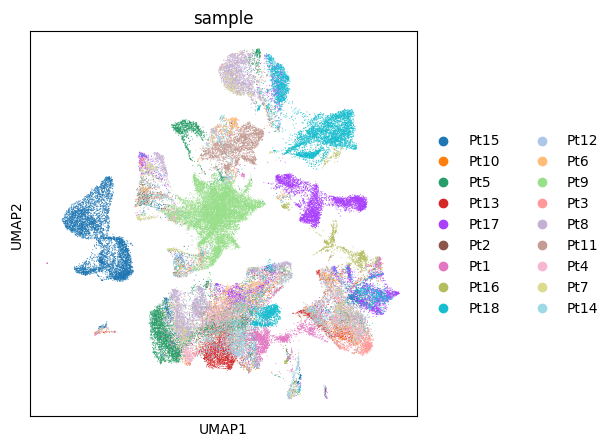

In [6]:
# UMAP 시각화
sc.pp.neighbors(adata)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, color='sample', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

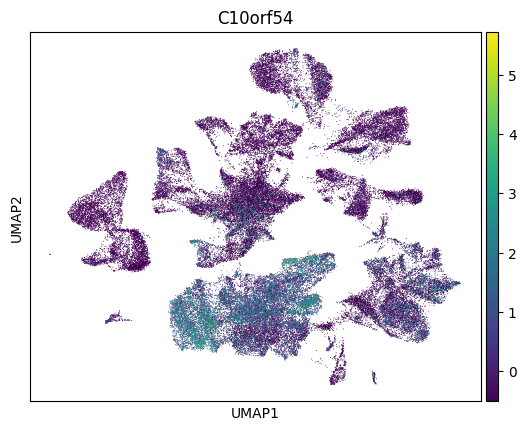

In [8]:
sc.pl.umap(
    adata,
    color = ['C10orf54']
)

2024-11-22 16:54:39,091 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-22 16:54:47,150 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-22 16:54:47,367 - harmonypy - INFO - Iteration 1 of 30
2024-11-22 16:54:59,093 - harmonypy - INFO - Iteration 2 of 30
2024-11-22 16:55:10,512 - harmonypy - INFO - Iteration 3 of 30
2024-11-22 16:55:23,183 - harmonypy - INFO - Iteration 4 of 30
2024-11-22 16:55:36,005 - harmonypy - INFO - Iteration 5 of 30
2024-11-22 16:55:48,656 - harmonypy - INFO - Iteration 6 of 30
2024-11-22 16:56:01,234 - harmonypy - INFO - Iteration 7 of 30
2024-11-22 16:56:13,989 - harmonypy - INFO - Iteration 8 of 30
2024-11-22 16:56:26,441 - harmonypy - INFO - Iteration 9 of 30
2024-11-22 16:56:37,101 - harmonypy - INFO - Iteration 10 of 30
2024-11-22 16:56:45,840 - harmonypy - INFO - Converged after 10 iterations


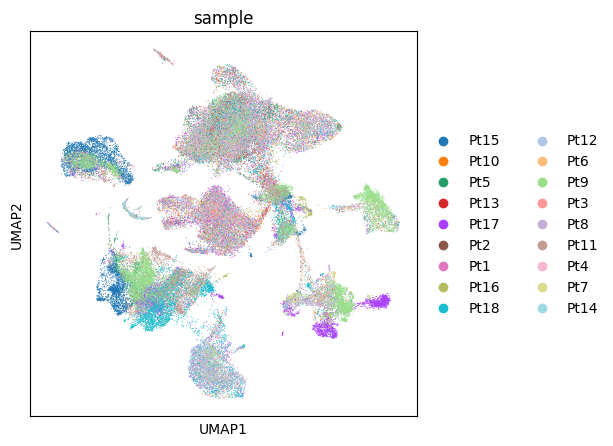

In [9]:
# Harmony로 배치 보정
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'sample', max_iter_harmony = 30)
adata.obsm['X_pca_harmony'] = ho.Z_corr.T  # Harmony 보정된 PCA 결과를 저장

# UMAP 시각화
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)
fig = sc.pl.umap(adata, color='sample', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

In [10]:
# leiden clustering
sc.tl.leiden(adata, resolution=1)
fig = sc.pl.umap(adata, color='leiden', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

/tmp/ipykernel_87110/1460678021.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


KeyboardInterrupt: 

In [ ]:
sc.pl.umap(
    adata,
    color = ['leiden', 'CD4', 'CD8A']
)